In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
import matplotlib as mpl

import numpy as np
import numpy.linalg as la

import time
import glob,os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

from PIL import Image
from imageio import imread


# Loading data

In [2]:
data_dir ="./commoncharacter>1250/"
os.listdir(data_dir)[0]
names = []
for j in os.listdir(data_dir):
    file = glob.glob(data_dir+j+"/*.png")[0]        
    names.append(file)

Print labels in the dataset

In [8]:
labels = np.load("./labels.npy") # printing labels
print("Chinese charactors learned by CNN:", )
print(labels)

Chinese charactors learned by CNN:
['一' '丁' '七' '三' '上' '下' '不' '且' '世' '中' '丸' '丹' '主' '久' '之' '九' '也' '乳'
 '乾' '了' '予' '事' '二' '云' '五' '亡' '交' '亦' '享' '京' '亭' '亮' '人' '什' '仁' '仇'
 '今' '介' '他' '付' '代' '令' '以' '仰' '仲' '件' '任' '伐' '休' '伯' '似' '但' '位' '低'
 '住' '何' '余' '作' '使' '例' '供' '侵' '便' '俊' '俗' '保' '信' '修' '倍' '倒' '候' '借'
 '停' '健' '傍' '催' '像' '元' '兄' '兆' '先' '光' '入' '全' '八' '公' '六' '共' '兵' '其'
 '具' '典' '再' '冒' '冬' '冷' '凡' '出' '函' '刀' '分' '切' '刊' '列' '初' '判' '利' '到'
 '制' '刷' '券' '刻' '前' '副' '割' '力' '功' '加' '助' '努' '勇' '勉' '勤' '勺' '包' '化'
 '北' '十' '千' '午' '半' '卒' '南' '博' '占' '印' '危' '卵' '厚' '原' '去' '又' '及' '友'
 '反' '取' '受' '口' '古' '句' '只' '召' '可' '台' '史' '右' '司' '吃' '各' '合' '同' '名'
 '后' '吐' '向' '君' '否' '含' '吸' '告' '周' '味' '呼' '命' '和' '品' '唐' '唯' '唱' '商'
 '善' '喜' '嘉' '器' '四' '回' '因' '困' '固' '土' '在' '地' '均' '垂' '型' '城' '域' '基'
 '堂' '堤' '塞' '境' '墓' '士' '夏' '夕' '外' '多' '夜' '大' '天' '太' '夫' '央' '失' '奇'
 '奉' '奏' '奔' '女' '好' '如' '妹' '妻' '始' '姐' '委']


## Get features from trained CNN 

ConvNet has 2 Convolutional layers and 2 Fully Connected layers. The model is trained in the IPython Notebook conv.ipynb and the parameters are saved.

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(8*8 * 64, 100)
        self.fc2 = nn.Linear(100, num_classes)
        
    def forward(self, x):
        
        out = self.layer1(x)
        conv_x = self.layer2[0](out)
        
        out = self.layer2(out)
        max_pool_x = out
        
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        
        out = self.fc1(out)
        out = self.fc2(out)
               
        return out, conv_x, max_pool_x

In [ ]:
model = torch.load("./conv_network_model") # load model
model.eval()


Resizing input images and converting them to a Tensor object

In [ ]:
size_IMG = 32
train_transforms = transforms.Compose([transforms.Resize(size_IMG),
                                       transforms.ToTensor(),
                                       ])

In [ ]:
tot_conv = []
tot_vect_conv = []
L = []
for j in os.listdir(data_dir):
        file = glob.glob(data_dir+j+"/*.png")[0]

        im = Image.open(file)

        tensorimage = train_transforms(im)

        outputs, visu_conv, visu_max_pool = model(tensorimage.view(1,1,size_IMG,size_IMG).cuda())
        
        vect_conv = visu_conv[0].view(-1).cpu().detach().numpy()  
        tot_vect_conv.append(vect_conv) 
        
        tot_conv.append(visu_conv[0].cpu().detach().numpy()) 

        _, predicted = torch.max(outputs.data, 1)
        print(j, labels[predicted]==j)
        L.append(j)


## Visualizing feature map of word 副

In [ ]:
plt.figure(figsize = (10,10))
f, axarr = plt.subplots(8,8, sharex=True)

for i in range(8):
    for j in range(8):
        axarr[i,j].imshow(visu_conv[0][i*8+j].cpu().detach().numpy())
        axarr[i,j].axis('off')
   
plt.show()

## Clustering the feature maps using K-means

In [156]:
use_cuda = torch.cuda.is_available()
dtype = 'float32' if use_cuda else 'float64'
torchtype = {'float32': torch.float32, 'float64': torch.float64}


# Naive K-means algorithm 
def KMeans(x, K=10, Niter=10, verbose=True):
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud,
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    start = time.time()
    c = x[:K, :].clone()  # Simplistic random initialization
    x_i = x[:, None, :]  # (Npoints, 1, D)
    
    for i in range(Niter):

        c_j = c[None, :, :]  # (1, Nclusters, D)
        
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances   
        cl = np.argmin(D_ij, axis = 1)  # Points -> Nearest cluster

        Ncl = torch.bincount(cl).type(torchtype[dtype])  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl

    end = time.time()

    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}:".format(N, D, K))
        print('Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n'.format(
                Niter, end - start, Niter, (end-start) / Niter))

    return cl, c, D_ij


In [91]:
tot_vect_conv = np.array(tot_vect_conv)
tor_data = torch.from_numpy(tot_vect_conv)
print(np.shape(tot_vect_conv))

(227, 16384)


Run K-means with 5 clusters

In [347]:
k = 5
cl, c, Dij = KMeans(tor_data, K=k)

K-means example with 227 points in dimension 16,384, K = 5:
Timing for 10 iterations: 3.55692s = 10 x 0.35569s



Printing out the resulting Clusters! 

In [348]:
for i in range(k):
    print("group%d:"%i, np.array(L)[np.where(cl.numpy()==i)])
    print("distance from the center:")
    print("group%d:"%i, np.round(np.sqrt(Dij[:,i]))[np.where(cl.numpy()==i)])


group0: ['何' '似' '什' '便' '信' '保' '件' '侵' '化' '仁' '但' '包' '反' '例' '公' '分' '代' '作'
 '倒' '使' '世' '也' '且' '付' '俗' '位' '后' '供' '任' '休' '丹' '伐' '句' '只' '仰' '低'
 '危' '可' '他' '倍' '住' '勺' '仲' '伯' '仇' '呼']
distance from the center:
group0: tensor([ 72.,  86.,  89.,  89.,  81.,  77.,  79.,  88.,  91., 105.,  76.,  83.,
         97.,  84.,  95.,  97.,  83.,  89.,  88.,  88.,  95.,  93.,  88.,  79.,
         78.,  75., 101.,  90.,  79.,  81., 103.,  85.,  90., 115.,  95.,  85.,
         91., 105.,  76.,  89.,  72., 107.,  84.,  90.,  86., 111.])
group1: ['刀' '之' '九' '入' '出' '丁' '十' '五' '刊' '不' '七' '元' '久' '三' '力' '二' '上' '印'
 '土' '兄' '口' '下' '天' '八' '六' '了' '士' '亡' '吐' '予' '人' '光' '北' '大' '太' '介'
 '一' '又' '云' '凡' '千' '四']
distance from the center:
group1: tensor([ 97.,  91.,  83.,  90.,  99., 104.,  91.,  95.,  94., 104.,  97.,  79.,
        100.,  97.,  91., 108.,  85., 104.,  83.,  96., 135.,  95.,  86.,  98.,
         91., 103.,  96., 101., 101., 102.,  94.,  98.,  85.,  81.,  89.,  98.,
       

## Using PCA vectors as the axis to plot the results

The clustering is happening in an extremely high dimensional space. We would like to visualize the clusters. One idea is to reduce the dimension of the feature space using PCA and plot the clusters along the eigenvectors that explain the most variance.

In [313]:
num = 3
X = tor_data

X_mean = torch.mean(X,0)
X = X - X_mean.expand_as(X)
U,S,V = torch.svd(torch.t(X))
C = torch.mm(X,U[:,:num])

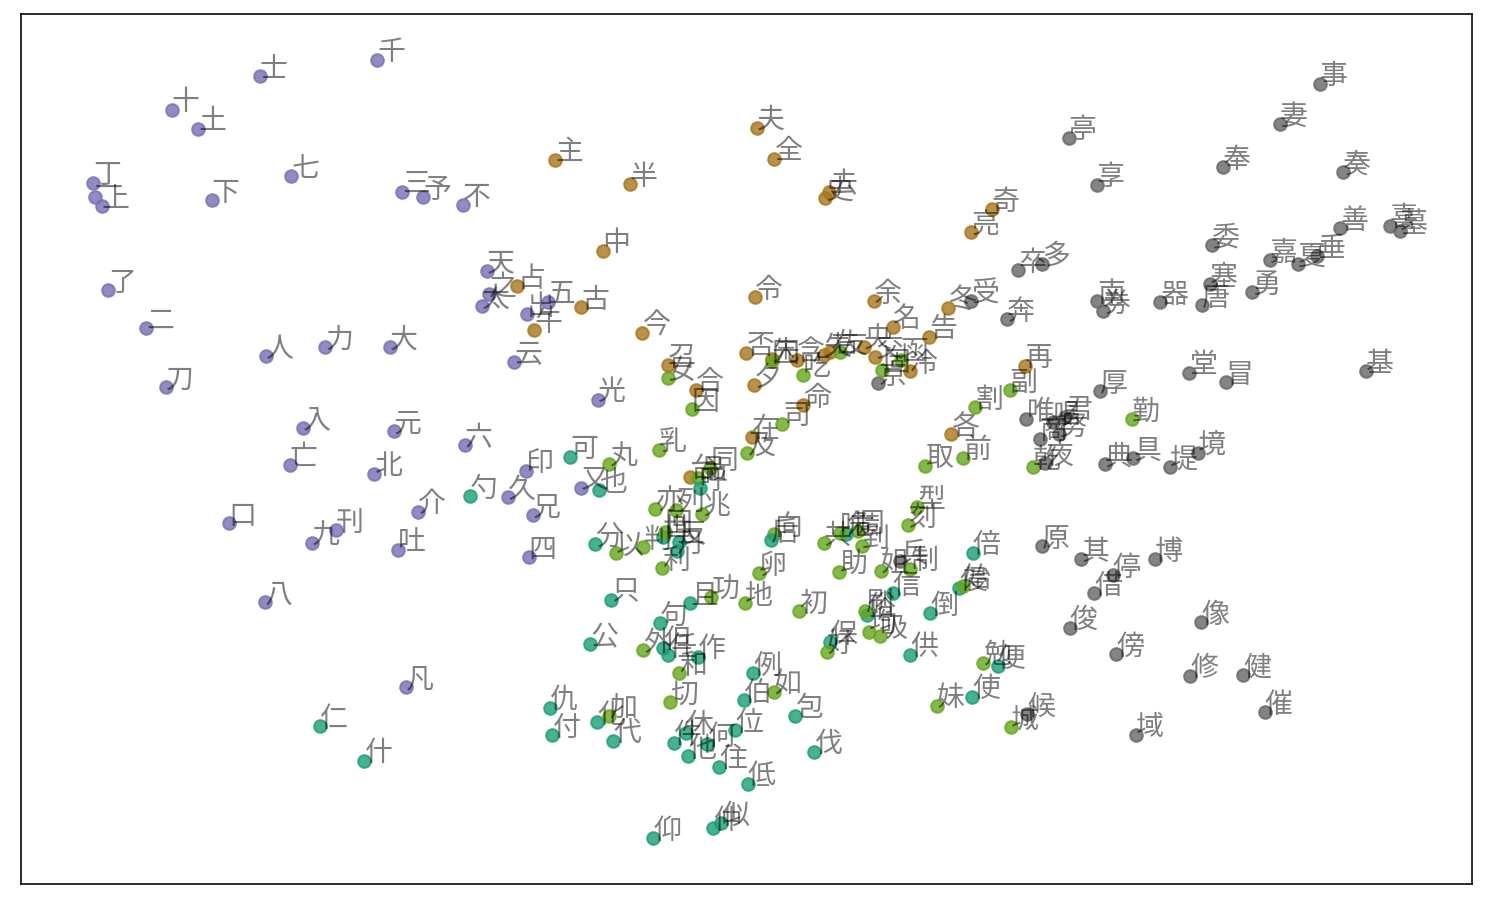

In [352]:
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
prop = mfm.FontProperties(fname=font_path)

plt.figure(figsize=(13,8))
cmap = plt.cm.get_cmap("Dark2", k)
for i in range(len(C)):
    plt.scatter(C.cpu()[i,0], C.cpu()[i,1], c = [cmap(cl.cpu()[i].numpy())], 
                s= 40, alpha = 0.8)
    plt.annotate(L[i], (C.cpu()[i,0], C.cpu()[i,1]), fontproperties=prop, size = 14, alpha = 0.5)

plt.xticks([],[])
plt.yticks([],[])
plt.savefig("./cluster_results.png")